## Importing Required Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
import string
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

## Import, Drop Null, Explore, Split Dataset

In [2]:
df = pd.read_csv('/kaggle/input/fake-news/train.csv')   

In [3]:
df.isna().sum()

id           0
title      558
author    1957
text        39
label        0
dtype: int64

In [4]:
#Dropping Columns having Null Values
df.dropna(inplace=True)
df.isna().sum()

id        0
title     0
author    0
text      0
label     0
dtype: int64

In [5]:
#Splitting the Data in Training and Testing Dataset
df_train, df_test = train_test_split(df, test_size=0.2, random_state=10)
df_train.reset_index(inplace=True)
df_test.reset_index(inplace=True)

In [6]:
df.head(5)

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


Text(0.5, 1.0, 'Testing')

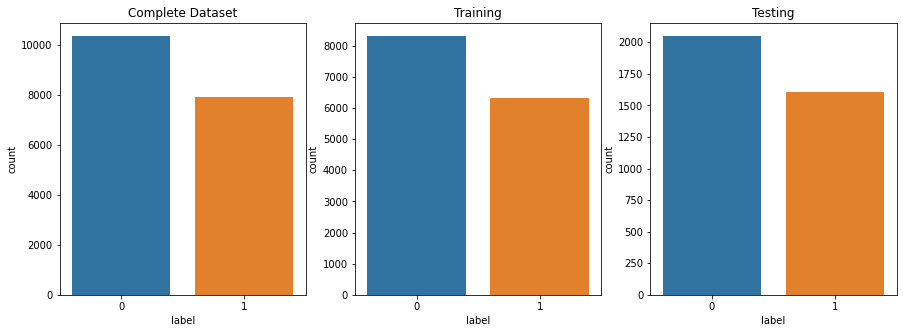

In [7]:
#Plotting Count VS Label 
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
sns.countplot(data=df,
             x='label')
plt.title('Complete Dataset')

plt.subplot(1,3,2)
sns.countplot(data=df_train,
             x='label')
plt.title('Training')

plt.subplot(1,3,3)
sns.countplot(data=df_test,
             x='label')
plt.title('Testing')

In [8]:
#Using only 'text' column for Training and Testing 
x_train, y_train = df_train['text'].values, df_train['label'].values
x_test, y_test = df_test['text'].values, df_test['label'].values

## Preparing Training and Testing Data using NLTK library

In [9]:
#Getting list of stopwods and punctuation
stops = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stops.update(punctuation)

#### Lemmatization

In [10]:
from nltk.corpus import wordnet
def get_simple_pos(tag):
    
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [11]:
# Using Lemmatization to clean the Words
def clean_text_l(text):
    output=[]
    lemmatizer = WordNetLemmatizer()
    words = word_tokenize(text)
    for w in words:
        if w.isalpha():
            if w.lower() not in stops:
                pos = pos_tag([w])
                clean_word = lemmatizer.lemmatize(w, pos = get_simple_pos(pos[0][1]))
                output.append(clean_word.lower())
    return " ".join(output)

#### Porter Stemmer

In [12]:
# Using Porter Stemmer to clean the Words
def clean_text_ps(text):
    output=[]
    ps = PorterStemmer()
    words = word_tokenize(text)
    for w in words:
        if w.isalpha():
            if w.lower() not in stops:
                output.append(ps.stem(w))
    return " ".join(output)

#### Defining Vectorizers

In [13]:
cv = CountVectorizer(max_features=5000, ngram_range=(1,3))
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,3))

## Model Training, Tuning and Testing

In [14]:
def print_score(clf, xtrain, ytrain, xtest, ytest):
    clf.fit(xtrain,ytrain)
    print('Training Score: ', clf.score(xtrain,ytrain))
    print('Testing Score:', clf.score(xtest,ytest))
    ypred=clf.predict(xtest)
    print('Confusion Matrix:','\n',confusion_matrix(ytest, ypred))

In [15]:
mnb = MultinomialNB()

#Case 1
#1.Cleaning using Lemmatization
x_train_l = []
for t in x_train:
    x_train_l.append(clean_text_l(t))
    
x_test_l = []
for t in x_test:
    x_test_l.append(clean_text_l(t))

#1.1.Selecting Features using Count Vectorizer
x_train_l_cv = cv.fit_transform(x_train_l)
x_test_l_cv = cv.transform(x_test_l)

print('-------------------------------------------------------')
print('Cleaning using Lemmatization')
print('Selecting Features using Count Vectorizer')
print_score(mnb, x_train_l_cv, y_train, x_test_l_cv, y_test)
print('-------------------------------------------------------')

#1.2.Selecting Features using TF-IDF Vectorizer
x_train_l_tfidf = tfidf.fit_transform(x_train_l)
x_test_l_tfidf = tfidf.transform(x_test_l)

print('-------------------------------------------------------')
print('Cleaning using Lemmatization')
print('Selecting Features using TF-IDF Vectorizer')
print_score(mnb, x_train_l_tfidf, y_train, x_test_l_tfidf, y_test)
print('-------------------------------------------------------')

-------------------------------------------------------
Cleaning using Lemmatization
Selecting Features using Count Vectorizer
Training Score:  0.8879546076018594
Testing Score: 0.8810500410172273
Confusion Matrix: 
 [[1901  149]
 [ 286 1321]]
-------------------------------------------------------
-------------------------------------------------------
Cleaning using Lemmatization
Selecting Features using TF-IDF Vectorizer
Training Score:  0.8891167623735302
Testing Score: 0.874487284659557
Confusion Matrix: 
 [[1933  117]
 [ 342 1265]]
-------------------------------------------------------


In [16]:
mnb = MultinomialNB()

#Case 2
#2.Cleaning using Porter Stemmer
x_train_ps = []
for t in x_train:
    x_train_ps.append(clean_text_ps(t))
    
x_test_ps = []
for t in x_test:
    x_test_ps.append(clean_text_ps(t))

#2.1.Selecting Features using Count Vectorizer
x_train_ps_cv = cv.fit_transform(x_train_ps)
x_test_ps_cv = cv.transform(x_test_ps)

print('-------------------------------------------------------')
print('Cleaning using Porter Stemmer')
print('Selecting Features using Count Vectorizer')
print_score(mnb, x_train_ps_cv, y_train, x_test_ps_cv, y_test)
print('-------------------------------------------------------')

#2.2.Selecting Features using TF-IDF Vectorizer
x_train_ps_tfidf = tfidf.fit_transform(x_train_ps)
x_test_ps_tfidf = tfidf.transform(x_test_ps)

print('-------------------------------------------------------')
print('Cleaning using Porter Stemmer')
print('Selecting Features using TF-IDF Vectorizer')
print_score(mnb, x_train_ps_tfidf, y_train, x_test_ps_tfidf, y_test)
print('-------------------------------------------------------')

-------------------------------------------------------
Cleaning using Porter Stemmer
Selecting Features using Count Vectorizer
Training Score:  0.8882964178288214
Testing Score: 0.8810500410172273
Confusion Matrix: 
 [[1900  150]
 [ 285 1322]]
-------------------------------------------------------
-------------------------------------------------------
Cleaning using Porter Stemmer
Selecting Features using TF-IDF Vectorizer
Training Score:  0.8893902105550998
Testing Score: 0.8780421110199618
Confusion Matrix: 
 [[1940  110]
 [ 336 1271]]
-------------------------------------------------------


In [18]:
param_grid = {'alpha':[0,0.1,0.5,0.01,0.05,0.001]}

mnb_gs = GridSearchCV(mnb, param_grid = param_grid, cv = 5, verbose = True)
mnb_gs.fit(x_train_ps_cv, y_train)
best_mnb = mnb_gs.best_estimator_
print('Best Estimator: ','\n', best_mnb)
print_score(best_mnb, x_train_ps_cv, y_train, x_test_ps_cv, y_test)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


/opt/conda/lib/python3.7/site-packages/sklearn/naive_bayes.py:509: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/opt/conda/lib/python3.7/site-packages/sklearn/naive_bayes.py:509: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/opt/conda/lib/python3.7/site-packages/sklearn/naive_bayes.py:509: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/opt/conda/lib/python3.7/site-packages/sklearn/naive_bayes.py:509: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/opt/conda/lib/python3.7/site-packages/sklearn/naive_bayes.py:509: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


Best Estimator:  
 MultinomialNB(alpha=0)
Training Score:  0.890278917145201
Testing Score: 0.8835110746513536
Confusion Matrix: 
 [[1911  139]
 [ 287 1320]]


/opt/conda/lib/python3.7/site-packages/sklearn/naive_bayes.py:509: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/opt/conda/lib/python3.7/site-packages/sklearn/naive_bayes.py:509: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
